In [2]:
import math
import geopandas as gpd
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
import geoplot as gplt
import geoplot.crs as gcrs
import contextily as cx
import matplotlib.pyplot as plt
from GeoConformalizedExplainer import GeoConformalizedExplainer

In [3]:
data = pd.read_csv('../data/seattle_sample_3k.csv')

In [4]:
data = gpd.GeoDataFrame(data, crs="EPSG:32610", geometry=gpd.points_from_xy(x=data.UTM_X, y=data.UTM_Y))

In [5]:
data = data.to_crs(4326)

In [6]:
data['lat'] = data['geometry'].get_coordinates()['x']

In [7]:
data['lon'] = data['geometry'].get_coordinates()['y']

In [8]:
data['price'] = np.power(10, data['log_price']) / 10000

In [9]:
data.to_file('../data/seattle_sample_3k.gpkg')

In [10]:
x_min, y_min, x_max, y_max = data.total_bounds

In [11]:
n_cols = 4

In [12]:
cell_size = (x_max - x_min) / n_cols

In [13]:
n_rows = math.ceil((y_max - y_min) / cell_size)

In [14]:
import shapely

In [15]:
grid_cells = []
for x0 in np.arange(x_min, x_max + cell_size, cell_size):
    for y0 in np.arange(y_min, y_max + cell_size, cell_size):
        print(x0)
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )
cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'],
                                 crs='EPSG:4326')

-122.463
-122.463
-122.463
-122.463
-122.463
-122.463
-122.463
-122.36474999999999
-122.36474999999999
-122.36474999999999
-122.36474999999999
-122.36474999999999
-122.36474999999999
-122.36474999999999
-122.26649999999998
-122.26649999999998
-122.26649999999998
-122.26649999999998
-122.26649999999998
-122.26649999999998
-122.26649999999998
-122.16824999999997
-122.16824999999997
-122.16824999999997
-122.16824999999997
-122.16824999999997
-122.16824999999997
-122.16824999999997
-122.06999999999996
-122.06999999999996
-122.06999999999996
-122.06999999999996
-122.06999999999996
-122.06999999999996
-122.06999999999996
-121.97174999999996
-121.97174999999996
-121.97174999999996
-121.97174999999996
-121.97174999999996
-121.97174999999996
-121.97174999999996


In [16]:
grid_cells = []

for i in range(n_cols):
    for j in range(n_rows):
        x0 = x_min + cell_size * i
        y0 = y_min + cell_size * j
        x1 = x_min + cell_size * (i + 1)
        y1 = y_min + cell_size * (j + 1)
        grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )

cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'],
                                 crs='EPSG:4326')

In [17]:
cell.to_file('./cells.gpkg')

<GeoAxes: >

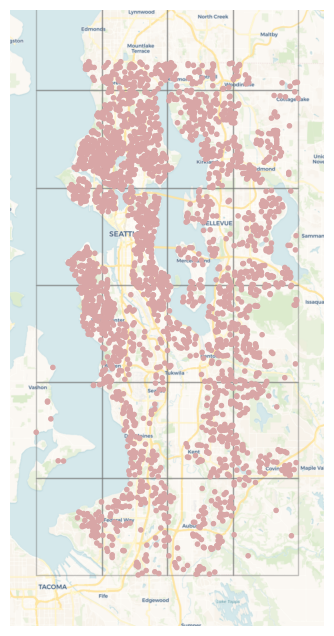

In [18]:
utm = gcrs.WebMercator()

ax = gplt.webmap(data, projection=utm, figsize=(15,8), provider=cx.providers.CartoDB.Voyager)

gplt.polyplot(cell, zorder=1, linewidth=1, edgecolor='#707070', ax=ax, alpha=0.4)

gplt.pointplot(data, ax=ax, s=3, color='#d8a6a6', zorder=10)

In [19]:
cell.head(5)

,geometry
0,"POLYGON ((-122.36475 47.25740, -122.36475 47.3..."
1,"POLYGON ((-122.36475 47.35565, -122.36475 47.4..."
2,"POLYGON ((-122.36475 47.45390, -122.36475 47.5..."
3,"POLYGON ((-122.36475 47.55215, -122.36475 47.6..."
4,"POLYGON ((-122.36475 47.65040, -122.36475 47.7..."


In [20]:
data_ = gpd.sjoin(data, cell, how='inner', predicate='within')

In [21]:
data_.head(5)

,Unnamed: 0,bathrooms,sqft_living,sqft_lot,grade,condition,waterfront,view,age,UTM_X,UTM_Y,log_price,geometry,lat,lon,price,index_right
0,0,3.00,2660,4600,8,3,0,0,109,552217.557035,5.274945e+06,6.091315,POINT (-122.30500 47.62580),-122.305,47.6258,123.40,9
1,1,2.25,2530,8736,7,4,0,0,57,565692.484331,5.272758e+06,5.790988,POINT (-122.12600 47.60490),-122.126,47.6049,61.80,21
2,2,2.00,1390,13464,7,4,0,0,28,562451.661509,5.245291e+06,5.315130,POINT (-122.17300 47.35810),-122.173,47.3581,20.66,13
3,3,1.00,940,4264,7,5,0,0,66,546816.935618,5.264407e+06,5.619093,POINT (-122.37800 47.53140),-122.378,47.5314,41.60,2
4,4,2.25,2070,7225,8,3,0,0,36,564343.195352,5.244978e+06,5.477121,POINT (-122.14800 47.35510),-122.148,47.3551,30.00,18


In [22]:
idxs = data_['index_right'].unique()

In [23]:
cell.shape

(24, 1)

In [24]:
N_parts, _ = cell.shape

In [25]:
def generate_groups(k: int):
    idxs = np.arange(k)
    return [(idx, list(idxs[idxs != idx])) for idx in idxs]

In [26]:
groups = generate_groups(N_parts)

In [27]:
results_list = []

In [29]:
for group in groups:
    idx, other_idxs = group
    test_data = data_[data_.index_right == idx]
    train_data = data_[data_.index_right.isin(other_idxs)]
    X_test = test_data[['bathrooms', 'sqft_living', 'sqft_lot', 'grade', 'condition', 'waterfront', 'view', 'age', 'UTM_X', 'UTM_Y']]
    y_test = test_data['price']
    loc_test = test_data[['lat', 'lon']]
    X_temp = train_data[['bathrooms', 'sqft_living', 'sqft_lot', 'grade', 'condition', 'waterfront', 'view', 'age', 'UTM_X', 'UTM_Y']]
    y_temp = train_data['price']
    loc_temp = train_data[['lat', 'lon']]
    X_train, X_calib, y_train, y_calib, loc_train, loc_calib  = train_test_split(X_temp, y_temp, loc_temp, train_size=0.2,
                                                                         random_state=42)
    model = xgb.XGBRegressor(n_estimators=500, max_depth=3, min_child_weight=1.0, colsample_bytree=1.0)
    model.fit(X_train, y_train)

    explainer = GeoConformalizedExplainer(model, X_train, X_calib, loc_calib.values, loc_test.values, 0.1, 0.15)
    result = explainer.uncertainty_aware_explain(x_test=X_test)
    results_list.append(result)


100%|██████████| 10/10 [00:57<00:00,  5.71s/it][A

100%|██████████| 10/10 [00:42<00:00,  4.27s/it][A

100%|██████████| 10/10 [00:40<00:00,  4.08s/it][A

100%|██████████| 10/10 [00:39<00:00,  3.95s/it][A

100%|██████████| 10/10 [00:49<00:00,  4.99s/it][A

100%|██████████| 10/10 [00:44<00:00,  4.49s/it][A

100%|██████████| 10/10 [00:41<00:00,  4.13s/it][A

100%|██████████| 10/10 [00:52<00:00,  5.21s/it][A

100%|██████████| 10/10 [00:45<00:00,  4.58s/it][A

100%|██████████| 10/10 [00:40<00:00,  4.06s/it][A

100%|██████████| 10/10 [00:39<00:00,  3.92s/it][A

100%|██████████| 10/10 [00:42<00:00,  4.27s/it][A

100%|██████████| 10/10 [00:40<00:00,  4.05s/it][A

100%|██████████| 10/10 [00:40<00:00,  4.05s/it][A

100%|██████████| 10/10 [00:40<00:00,  4.03s/it][A

100%|██████████| 10/10 [00:38<00:00,  3.83s/it][A

100%|██████████| 10/10 [00:41<00:00,  4.20s/it][A

100%|██████████| 10/10 [00:43<00:00,  4.33s/it][A

100%|██████████| 10/10 [00:40<00:00,  4.02s/it][A

100%|██████████| 10/10 [00:39<

In [30]:
results_list

In [32]:
results_list[0].result

,bathrooms_shap,sqft_living_shap,sqft_lot_shap,grade_shap,condition_shap,waterfront_shap,view_shap,age_shap,UTM_X_shap,UTM_Y_shap,...,UTM_X_coverage_probability,UTM_X_pred,UTM_Y_geo_uncertainty,UTM_Y_uncertainty,UTM_Y_upper_bound,UTM_Y_lower_bound,UTM_Y_coverage_probability,UTM_Y_pred,x,y
0,-0.763974,-3.997368,1.452581,-2.838845,-0.563421,-0.001736,-1.333566,-2.534853,1.662184,-17.177214,...,0.733333,0.490180,2.278663,2.9411,-15.874734,-20.432060,0.844444,-18.153397,-122.373,47.3020
1,0.639273,-3.809065,3.690404,1.893933,0.487957,-0.001736,-1.176621,-2.447852,7.286382,-15.562569,...,0.733333,5.357040,2.305288,2.9411,-15.004848,-19.615425,0.844444,-17.310137,-122.385,47.3074
2,0.539109,-3.657321,0.805293,1.789086,-0.726077,-0.001736,-1.308715,-2.193038,0.334608,-16.587162,...,0.733333,1.126942,2.305288,2.9411,-14.806305,-19.416882,0.844444,-17.111593,-122.369,47.3122
3,-1.872418,-9.983788,1.002040,-6.702856,-0.476831,-0.001736,-1.189065,-1.108301,-0.403389,-14.871179,...,0.733333,-0.033811,2.284925,2.9411,-12.387809,-16.957661,0.844444,-14.672734,-122.371,47.3066
4,-0.123227,-1.898743,-0.177650,9.624029,-0.726407,-0.001736,-1.234978,-4.018608,8.802073,-16.989941,...,0.733333,5.716518,2.312809,2.9411,-16.479473,-21.105091,0.844444,-18.792282,-122.393,47.3079
5,-0.613909,0.873803,1.102432,1.490952,-0.602623,-0.001736,-1.167977,-2.003629,8.043503,-16.931158,...,0.733333,5.785346,2.335505,2.9411,-16.240179,-20.911188,0.844444,-18.575684,-122.392,47.3199
6,-2.811446,-6.183880,1.905684,-8.383801,0.652772,-0.001736,-1.070949,1.407894,11.953402,-12.747706,...,0.733333,6.705439,2.362772,2.9411,-13.224812,-17.950356,0.844444,-15.587584,-122.399,47.3215
7,-0.436750,-1.884551,0.171955,-0.342454,0.109511,-0.001736,-1.255307,-1.057618,4.979198,-18.674870,...,0.733333,5.063642,2.307376,2.9411,-17.003628,-21.618378,0.844444,-19.311003,-122.376,47.3112
8,-0.504122,-9.415550,3.467280,-3.545158,0.502462,-0.001736,-1.108996,3.810866,12.407497,-12.621428,...,0.733333,7.690166,2.361396,2.9411,-12.606492,-17.329285,0.844444,-14.967888,-122.397,47.3206
9,0.117272,-3.858093,2.574614,14.699052,1.905221,-0.001736,-1.077900,0.038323,9.656052,-16.337923,...,0.733333,6.064948,2.312809,2.9411,-16.749809,-21.375427,0.844444,-19.062618,-122.382,47.3165


In [33]:
feature_names = ['bathrooms',
 'sqft_living',
 'sqft_lot',
 'grade',
 'condition',
 'waterfront',
 'view',
 'age',
 'UTM_X',
 'UTM_Y']

In [34]:
cell_uncertainty_list = {}

for name in feature_names:
    uncertainty_list = []
    for i in range(N_parts):
        result = results_list[i].result_geo
        uncertainty = result[f'{name}_uncertainty'][0]
        uncertainty_list.append(uncertainty)
    cell_uncertainty_list[name] = uncertainty_list

for key, value in cell_uncertainty_list.items():
    cell[f'{key}_uncertainty'] = value

In [35]:
cell

,geometry,bathrooms_uncertainty,sqft_living_uncertainty,sqft_lot_uncertainty,grade_uncertainty,condition_uncertainty,waterfront_uncertainty,view_uncertainty,age_uncertainty,UTM_X_uncertainty,UTM_Y_uncertainty
0,"POLYGON ((-122.36475 47.25740, -122.36475 47.3...",1.143728,2.790390,2.054895,1.039336,0.455337,0.000076,0.413418,2.552303,2.355622,2.941100
1,"POLYGON ((-122.36475 47.35565, -122.36475 47.4...",0.864815,2.787993,2.007847,1.658663,0.491806,0.000000,0.212420,2.612791,2.196496,2.499895
2,"POLYGON ((-122.36475 47.45390, -122.36475 47.5...",1.122441,2.863538,2.111880,1.586219,0.421270,0.000693,0.192214,2.350622,2.362089,3.487441
3,"POLYGON ((-122.36475 47.55215, -122.36475 47.6...",1.076057,3.094263,2.066454,1.118662,0.547673,0.003664,0.408754,1.939130,2.933363,2.859191
4,"POLYGON ((-122.36475 47.65040, -122.36475 47.7...",1.031236,2.338527,2.322058,1.017370,0.471512,0.000367,0.196601,1.932610,2.402572,2.911533
5,"POLYGON ((-122.36475 47.74865, -122.36475 47.8...",0.657072,3.575174,2.306100,1.701048,0.566092,0.000056,0.227376,2.208624,2.479018,3.572971
6,"POLYGON ((-122.26650 47.25740, -122.26650 47.3...",0.946939,2.925681,2.440447,1.432198,0.558016,0.002534,0.378601,1.959335,2.693512,3.079864
7,"POLYGON ((-122.26650 47.35565, -122.26650 47.4...",0.728918,3.070833,2.312503,1.637352,0.481409,0.000115,0.143940,2.159258,2.977746,2.943505
8,"POLYGON ((-122.26650 47.45390, -122.26650 47.5...",1.119396,3.163863,2.257758,1.040032,0.430074,0.000000,0.275230,1.829039,2.446064,2.674642
9,"POLYGON ((-122.26650 47.55215, -122.26650 47.6...",0.882645,2.641399,1.998981,0.792891,0.234620,0.000378,0.278971,1.711742,1.871996,2.269746


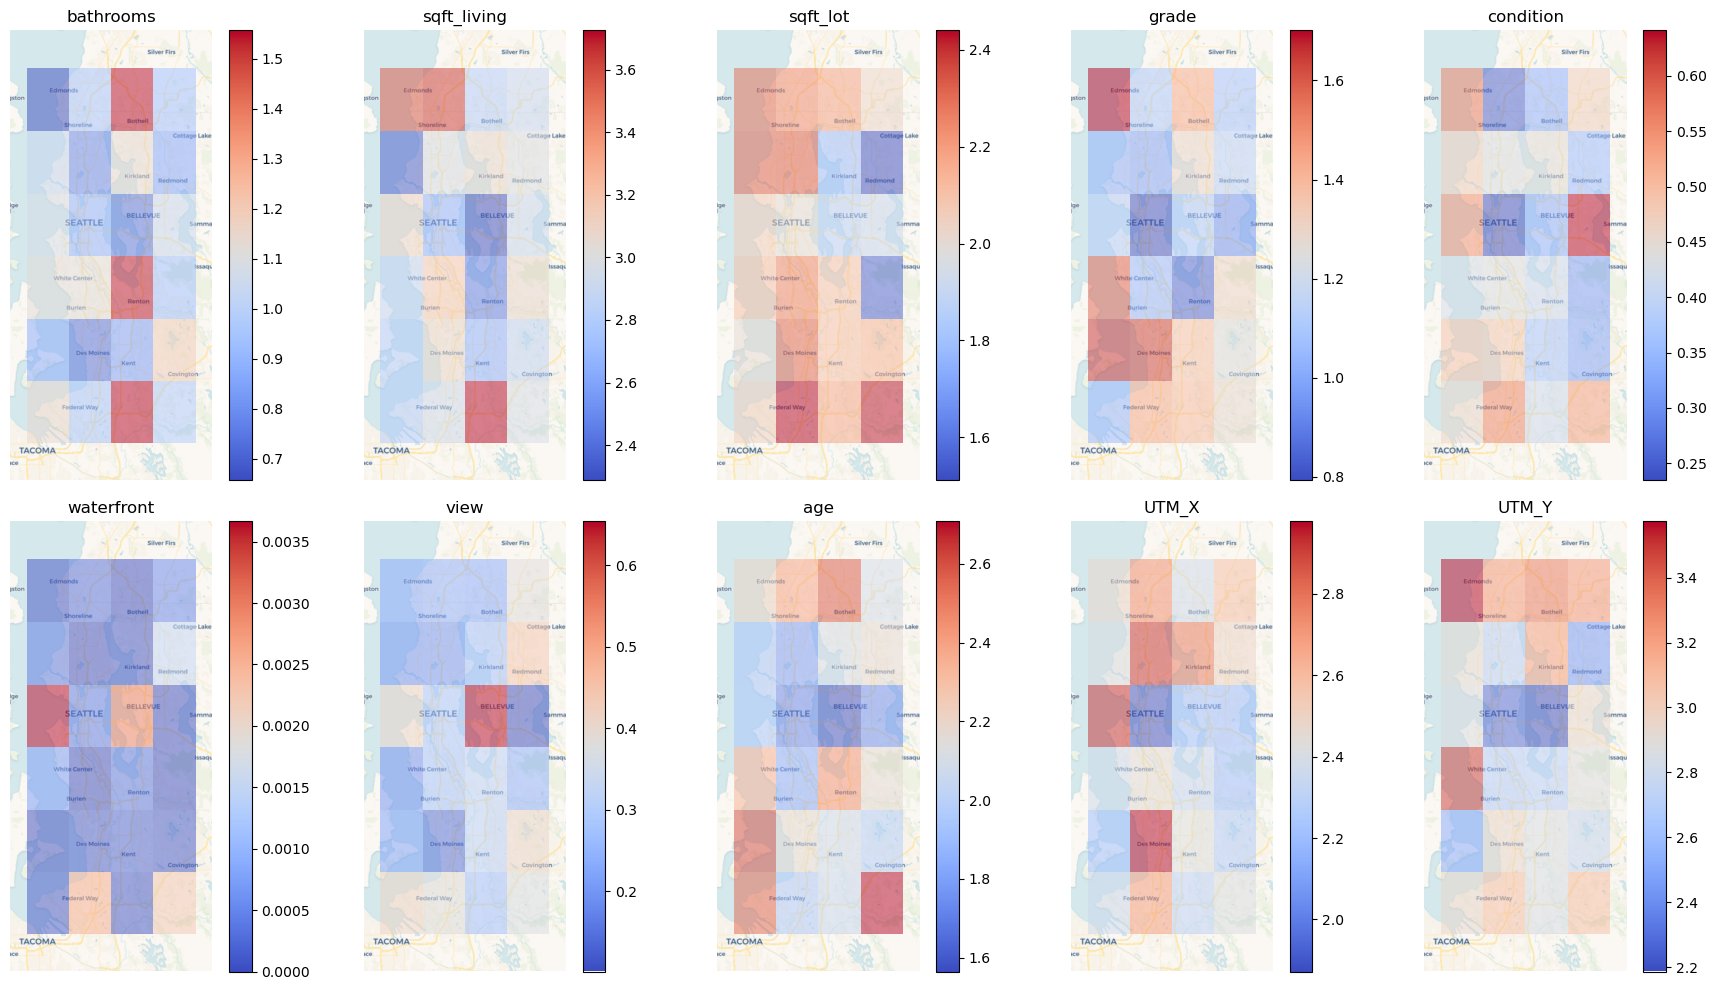

In [44]:
utm = gcrs.WebMercator()

fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(18, 10), subplot_kw={'projection': utm})

for i in range(len(feature_names)):
    row = int(i // 5)
    col = i - row * 5
    ax = axes[row][col]

    name = feature_names[i]

    ax.set_title(name)

    gplt.webmap(cell, projection=utm, provider=cx.providers.CartoDB.Voyager, ax=ax)

    ax.set_axis_on()

    gplt.choropleth(cell, hue=f'{name}_uncertainty', cmap='coolwarm', legend=True, legend_kwargs={'shrink':1}, ax=ax, alpha=0.5)
plt.tight_layout()